In [1]:
%matplotlib inline
import IPython.display
from ipywidgets import interact, interactive, fixed

import numpy as np
from scipy.io import wavfile
from utils import butter_bandpass_filter, get_timit_dict, get_target, create_mel_filter, pretty_spectrogram, make_mel
import matplotlib.pyplot as plt

In [2]:
# preprocess feature data
rate, data = wavfile.read("data/LDC93S1.wav")
data = butter_bandpass_filter(data, 500, 7999, rate, order=1)
#IPython.display.Audio(data=data, rate=rate)

Text(0.5,1.05,'Original Spectrogram')

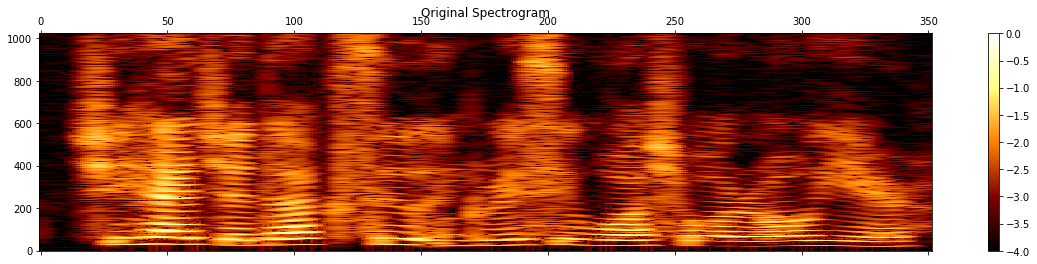

In [3]:
wav_spectrogram = pretty_spectrogram(data.astype('float64'), fft_size=2048,
                                     step_size=128, thresh=4)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,4))
cax = ax.matshow(np.transpose(wav_spectrogram), interpolation='nearest', aspect='auto', cmap=plt.cm.afmhot, origin='lower')
fig.colorbar(cax)
plt.title('Original Spectrogram')

In [4]:
mel_filter, mel_inversion_filter = create_mel_filter(fft_size=2048,
                                                     n_freq_components=64,
                                                     start_freq=300,
                                                     end_freq=8000)
mel_spec = make_mel(wav_spectrogram, mel_filter, shorten_factor=10)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,4))
cax = ax.matshow(mel_spec, interpolation='nearest', aspect='auto', cmap=plt.cm.afmhot, origin='lower')
fig.colorbar(cax)
plt.title('mel Spectrogram')

Text(0.5,1.05,'mel Spectrogram')

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x0000029744958950> (for post_execute):


ValueError: Unsupported dtype

ValueError: Unsupported dtype

<Figure size 1440x288 with 2 Axes>